In [32]:
import json
import pprint
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation  
import matplotlib.pyplot as plt  
from sklearn.metrics import classification_report, confusion_matrix

pp = pprint.PrettyPrinter(indent=4)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#df = pd.read_csv('/root/data/small_pen_data_collection/freckles.csv', names=['id', 'file', 'eye_coordinate', 'freckle_coordinates'])
df = pd.read_csv('/root/data/reidentification/freckles.csv', names=['id', 'file', 'eye_coordinate', 'freckle_coordinates'])

In [3]:
df.loc[0]

len(df)

2881

In [4]:
def get_id_counts():
    fish_ids = np.unique(df['id'])

    id_count = {}

    for id in fish_ids:
        coordinates = df[df['id'] == id]['freckle_coordinates']
        non_zero_coordinates = [coordinate for coordinate in coordinates if len(json.loads(coordinate)) > 0]
        avg_coordinate_length = np.mean([ len(json.loads(coordinate)) for coordinate in non_zero_coordinates])
        coordinate_10 = np.percentile([ len(json.loads(coordinate)) for coordinate in non_zero_coordinates], 10)
        coordinate_90 = np.percentile([ len(json.loads(coordinate)) for coordinate in non_zero_coordinates], 90)
        id_count[id] = (len(df[df['id'] == id]), avg_coordinate_length, coordinate_10, coordinate_90)
        
        print('%i, %i, %i, %i' % (id, avg_coordinate_length, coordinate_10, coordinate_90))

    return id_count

get_id_counts()

180921010001, 29, 2, 58
181001010001, 2, 1, 4
181001010002, 31, 4, 67
181001010003, 11, 3, 23
181001010004, 12, 1, 27
181001010005, 12, 1, 27
181001010006, 7, 1, 11
181001010007, 6, 1, 14
181001010008, 4, 1, 9
181001010009, 19, 3, 39
181001010010, 23, 2, 54
181008010001, 109, 32, 223
181010010001, 80, 29, 123
181010010002, 98, 31, 177
181010010003, 102, 28, 161
181012010001, 126, 49, 236
181012010002, 41, 5, 103
181012010003, 42, 3, 85
181012010004, 60, 20, 103
181012010005, 168, 105, 270
181012010007, 43, 3, 78
181012010008, 14, 3, 32
181012010009, 42, 2, 122
181012010010, 16, 2, 33
181012010011, 123, 63, 158
181012010012, 89, 50, 134
181012010013, 12, 3, 23
181012010014, 137, 71, 197
181015010001, 130, 44, 258
181015010002, 145, 40, 204
181015010003, 93, 32, 164
181015010004, 152, 35, 243
181015010005, 122, 42, 203
181015010006, 128, 51, 190
181015010007, 103, 23, 158
181016010001, 131, 67, 214
181016010002, 140, 47, 229
181016010003, 53, 10, 97
181016010004, 176, 68, 253
18101601000

{180921010001: (48, 29.38095238095238, 2.200000000000001, 58.19999999999999),
 181001010001: (36, 2.4166666666666665, 1.0, 4.9),
 181001010002: (145, 31.412587412587413, 4.0, 67.8),
 181001010003: (191, 11.155172413793103, 3.0, 23.400000000000034),
 181001010004: (240, 12.182222222222222, 1.0, 27.0),
 181001010005: (93, 12.194029850746269, 1.0, 27.0),
 181001010006: (33, 7.222222222222222, 1.0, 11.600000000000001),
 181001010007: (121, 6.1265822784810124, 1.0, 14.400000000000006),
 181001010008: (124, 4.142857142857143, 1.0, 9.799999999999997),
 181001010009: (183, 19.064327485380115, 3.0, 39.0),
 181001010010: (174, 23.158940397350992, 2.0, 54.0),
 181008010001: (16, 109.5, 32.0, 223.0),
 181010010001: (54, 80.75925925925925, 29.100000000000005, 123.10000000000001),
 181010010002: (44, 98.68181818181819, 31.099999999999998, 177.20000000000005),
 181010010003: (43, 102.97674418604652, 28.6, 161.40000000000003),
 181012010001: (59, 126.44067796610169, 49.80000000000001, 236.000000000000

In [5]:
same_fish = df[df['id'] == 181016010007]

In [6]:
#for datum in same_fish:

datum = same_fish.iloc[0]

In [7]:
eye_coordinate = json.loads(datum['eye_coordinate'])
freckle_coordinates = json.loads(datum['freckle_coordinates'])

In [8]:
pca = PCA(n_components=2)

pca.fit(freckle_coordinates)

components = pca.components_

newEyeCoordinates = np.dot(eye_coordinate, components.T)
newFreckleCoordinates = np.dot(freckle_coordinates, components.T)

In [9]:
newEyeCoordinates

array([378.31528493, 130.78816913])

In [10]:
relativeCoordinates = newFreckleCoordinates - newEyeCoordinates

mean = np.mean(relativeCoordinates, axis=0)
stdev = np.std(relativeCoordinates, axis=0)

normalizedCoordinates = (relativeCoordinates - mean) / stdev

In [11]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(normalizedCoordinates)

In [12]:
kmeans.cluster_centers_.flatten()

array([-0.75984356, -0.04161388, -0.30634032,  1.57817731,  2.02299628,
       -0.76895179, -1.04236539, -1.47883421,  0.46099082,  0.17914607])

In [13]:
classifier = KNeighborsClassifier(n_neighbors=5)  

In [31]:
import pdb;

def generate_data(n_clusters, lower_thresh, higher_thresh):
    data = None
    ids = []

    for index, datum in df.iterrows():
        if index % 500 == 0:
            print('Processing %i out of %i' % (index, len(df)))
            
        eye_coordinate = json.loads(datum['eye_coordinate'])
        freckle_coordinates = json.loads(datum['freckle_coordinates'])

        if len(freckle_coordinates) < lower_thresh or len(freckle_coordinates) > higher_thresh:
            continue

        pca = PCA(n_components=2)

        pca.fit(freckle_coordinates)

        components = pca.components_

        newEyeCoordinates = np.dot(eye_coordinate, components.T)
        newFreckleCoordinates = np.dot(freckle_coordinates, components.T)

        relativeCoordinates = newFreckleCoordinates - newEyeCoordinates

        mean = np.mean(relativeCoordinates, axis=0)
        stdev = np.std(relativeCoordinates, axis=0)

        normalizedCoordinates = (relativeCoordinates - mean) / stdev

        kmeans = KMeans(n_clusters=n_clusters).fit(normalizedCoordinates)

        if data is None:
            data = kmeans.cluster_centers_.flatten()
        else:
            data = np.vstack((data, kmeans.cluster_centers_.flatten()))

        ids.append((datum['id'], len(freckle_coordinates)))
    
#     all_ids = np.array([id[0] for id in ids])
#     unique_ids = np.unique(all_ids)
#     max_id_count = 0
#     for id in unique_ids:
#         id_counts = np.sum(all_ids == id)
#         if id_counts > max_id_count:
#             max_id_count = id_counts
            
#     for id in unique_ids:
#         print('Augmenting id %i' % (id, ))

#         id_indices = all_ids == id
#         found_ids = [ myId for myId in ids if myId[0] == id ]
        
#         id_counts = np.sum(all_ids == id)
#         multiplier = max_id_count * 1.0 / id_counts #(1.0 / len(unique_ids)) / (id_counts * 1.0 / len(df))
        
#         for i in range(1, int(multiplier)):
#             data = np.vstack((data, data[np.where(id_indices)[0], :]))
#             ids = np.concatenate((ids, found_ids))
    
    return (data, ids)

In [27]:
X, y = generate_data(4, 20, 100)

Processing 0 out of 2881
Processing 100 out of 2881
Processing 200 out of 2881
Processing 300 out of 2881
Processing 400 out of 2881
Processing 500 out of 2881
Processing 600 out of 2881
Processing 700 out of 2881
Processing 800 out of 2881
Processing 900 out of 2881
Processing 1000 out of 2881
Processing 1100 out of 2881
Processing 1200 out of 2881
Processing 1300 out of 2881
Processing 1400 out of 2881
Processing 1500 out of 2881
Processing 1600 out of 2881
Processing 1700 out of 2881
Processing 1800 out of 2881
Processing 1900 out of 2881
Processing 2000 out of 2881
Processing 2100 out of 2881
Processing 2200 out of 2881
Processing 2300 out of 2881
Processing 2400 out of 2881
Processing 2500 out of 2881
Processing 2600 out of 2881
Processing 2700 out of 2881
Processing 2800 out of 2881


In [16]:
X

array([[ 1.47246772, -0.15824357, -0.14276441, ..., -1.31929781,
        -1.12465214, -0.06085016],
       [ 0.12555613,  1.2774917 , -0.53824177, ..., -0.65824085,
        -1.48327614, -1.50390322],
       [ 0.46835525, -0.46100203, -1.4887957 , ..., -0.83042362,
         1.31455666,  0.8720997 ],
       ...,
       [-0.70670141,  1.61442518,  1.04699204, ...,  0.66864499,
        -0.61415426, -0.4818702 ],
       [ 0.14968118, -0.68677387, -0.12689857, ..., -0.13979065,
        -1.07557938, -0.50695542],
       [-0.7469745 , -0.87812317,  1.90370239, ...,  1.2014616 ,
        -0.42543088,  0.43934618]])

In [28]:
def run_freckle_detection(n_clusters, max_n_neighbors):
    print('Generating dataset...')
    
    X, y = generate_data(n_clusters, 20, 100)
    
    error = []
    
    for i in range(1, max_n_neighbors): 
        print('Running for %i neighbors' % (i, ))
        
        total_error = []
        
        for j in range(1, 50):
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

            y_train_id = np.array([ y[0] for y in y_train ])
            y_test_id = np.array([ y[0] for y in y_test ])
            y_test_len = np.array([ y[1] for y in y_test ])

            # Calculating error for K values between 1 and 40

            knn = KNeighborsClassifier(n_neighbors=i)
            knn.fit(X_train, y_train_id)
            pred_i = knn.predict(X_test)
            total_error.append(np.mean(pred_i != y_test_id))
        
        error.append(np.mean(total_error))

    plt.figure(figsize=(12, 6))  
    plt.plot(range(1, max_n_neighbors), error, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')  
    plt.xlabel('K Value')  
    plt.ylabel('Mean Error')

Generating dataset...
Processing 0 out of 2881
Processing 100 out of 2881
Processing 200 out of 2881
Processing 300 out of 2881
Processing 400 out of 2881
Processing 500 out of 2881
Processing 600 out of 2881
Processing 700 out of 2881
Processing 800 out of 2881
Processing 900 out of 2881
Processing 1000 out of 2881
Processing 1100 out of 2881
Processing 1200 out of 2881
Processing 1300 out of 2881
Processing 1400 out of 2881
Processing 1500 out of 2881
Processing 1600 out of 2881
Processing 1700 out of 2881
Processing 1800 out of 2881
Processing 1900 out of 2881
Processing 2000 out of 2881
Processing 2100 out of 2881
Processing 2200 out of 2881
Processing 2300 out of 2881
Processing 2400 out of 2881
Processing 2500 out of 2881
Processing 2600 out of 2881
Processing 2700 out of 2881
Processing 2800 out of 2881
Running for 1 neighbors
Running for 2 neighbors
Running for 3 neighbors
Running for 4 neighbors
Running for 5 neighbors
Running for 6 neighbors
Running for 7 neighbors
Running fo

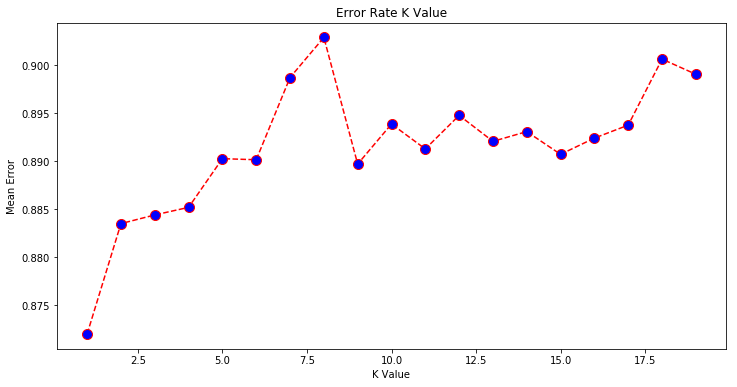

In [29]:
run_freckle_detection(4, 20)

In [ ]:
X, y = generate_data(4, 20, 100)

In [38]:
all_y_test_id = []
all_y_pred = []

#for i in range(1, 40):
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

y_train_id = np.array([ y[0] for y in y_train ])
y_test_id = np.array([ y[0] for y in y_test ])
y_test_len = np.array([ y[1] for y in y_test ])

knn = KNeighborsClassifier(n_neighbors=1)
#knn = RandomForestClassifier()
knn.fit(X_train, y_train_id)
y_pred = knn.predict(X_test)

all_y_test_id = np.concatenate((all_y_test_id, y_test_id))
all_y_pred = np.concatenate((all_y_pred, y_pred))
    
#y_pred == y_test_id

success_failure = y_pred == y_test_id
success_lens = y_test_len[success_failure == True]
failure_lens = y_test_len[success_failure == False]


#print(confusion_matrix(y_test, y_pred))  
print(classification_report(all_y_test_id, all_y_pred))  

                precision    recall  f1-score   support

180921010001.0       0.00      0.00      0.00         2
181001010002.0       0.18      0.11      0.14        18
181001010003.0       0.38      0.75      0.50         4
181001010004.0       0.00      0.00      0.00        10
181001010005.0       0.00      0.00      0.00         5
181001010007.0       0.00      0.00      0.00         1
181001010009.0       0.12      0.20      0.15        10
181001010010.0       0.25      0.18      0.21        11
181008010001.0       0.00      0.00      0.00         2
181010010001.0       0.18      0.29      0.22         7
181010010002.0       0.00      0.00      0.00         4
181010010003.0       0.00      0.00      0.00         5
181012010001.0       0.20      0.20      0.20         5
181012010002.0       0.00      0.00      0.00         0
181012010003.0       0.00      0.00      0.00         1
181012010004.0       0.00      0.00      0.00         3
181012010005.0       0.00      0.00      0.00  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [25]:

print(np.vstack((y_pred, y_test_id, success_failure, y_test_len)).T)

np.sum(all_y_test_id == all_y_pred)
len(all_y_pred)

[[181010010001 181010010001            1           95]
 [181016010006 181016010006            1           57]
 [181016010006 181016010006            1           77]
 ...
 [181016010004 181015010003            0           44]
 [181001010002 181001010002            1           49]
 [181012010002 181012010002            1           64]]


534

In [21]:
id_count = {}

for myY in y:
    id = myY[0]
    
    if id in id_count:
        id_count[id] = id_count[id] + 1
    else:
        id_count[id] = 1
        
pp.pprint(id_count)

pp.pprint(get_id_counts())

{   180921010001: 72,
    181001010002: 75,
    181001010003: 75,
    181001010004: 45,
    181001010005: 75,
    181001010006: 75,
    181001010007: 72,
    181001010008: 75,
    181001010009: 71,
    181001010010: 58,
    181008010001: 72,
    181010010001: 70,
    181010010002: 66,
    181010010003: 65,
    181012010001: 72,
    181012010002: 68,
    181012010003: 66,
    181012010004: 52,
    181012010005: 75,
    181012010007: 70,
    181012010008: 70,
    181012010009: 66,
    181012010010: 65,
    181012010011: 72,
    181012010012: 40,
    181012010013: 72,
    181012010014: 65,
    181015010001: 72,
    181015010002: 72,
    181015010003: 45,
    181015010004: 63,
    181015010005: 52,
    181015010006: 52,
    181015010007: 54,
    181016010001: 70,
    181016010002: 63,
    181016010003: 62,
    181016010004: 72,
    181016010005: 65,
    181016010006: 69,
    181016010007: 40}
180921010001, 29, 2, 58
181001010001, 2, 1, 4
181001010002, 31, 4, 67
181001010003, 11, 3, 23
1810

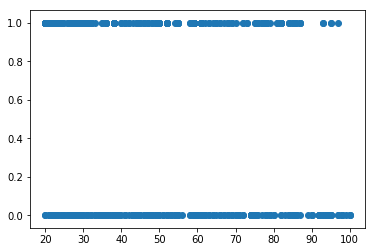

NameError: name 'success_lens' is not defined

In [22]:
plt.scatter(y_test_len, y_pred == y_test_id)
plt.show()

percentiles = []
success_percentiles = []
failure_percentiles = []

for i in range(0, 100, 5):
    p1 = np.percentile(success_lens, i) # return 50th percentile, e.g median.
    p2 = np.percentile(failure_lens, i) # return 50th percentile, e.g median.
    
    percentiles.append(i)
    success_percentiles.append(p1)
    failure_percentiles.append(p2)
    
    print('%0.2f: %0.2f, %0.2f' % (i, p1, p2))
    
plt.plot(percentiles, success_percentiles)
plt.plot(percentiles, failure_percentiles)
plt.show()